In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
#solve nash bargaining with one insurer

def calc_shares1(p1, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp - p1)/cost
    s1 = np.exp(u1)/(np.exp(u1) + 1 )
    return s1
  

def calc_profits_price_shares1(phi1,cost,wtp,mc1):
    pi1 = lambda p : -1*calc_shares1(p, cost, wtp)[0]*(p-phi1 -mc1)
    p1 = minimize(pi1,1,method='Nelder-Mead',tol=1e-4).x
    s1 = calc_shares1(p1,  cost, wtp)
    return p1[0], s1[0], s1[0]*(p1[0]-phi1 -mc1)

def nash_in_nash_obj1(phi1, cost, wtp, mc1, beta=.5):
    p1,s1,profits1 = calc_profits_price_shares1(phi1, cost, wtp, mc1)
    hosp_profit = s1*phi1
    obj = -1*(np.log(hosp_profit)*(1-beta) + np.log(profits1)*beta)

    #print(obj)
    return obj

def nash_in_nash1(cost,wtp,mc1,outside_option=False):
    obj1 = lambda phi : nash_in_nash_obj1(phi,cost,wtp,mc1)
    result = minimize(obj1,13,method='Nelder-Mead',tol=1e-4)
    
    if outside_option:
        return result.x[0]*calc_shares1(result.x[0], cost, wtp)
    return result.x[0]

#solve nash bargaining with 2 insurers

def calc_shares(p1, p2,  cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp[0] - p1)/cost
    u2 = (wtp[1] - p2)/cost
    s1 = np.exp(u1)/(np.exp(u1)+ np.exp(u2) + 1 )
    s2 = np.exp(u2)/(np.exp(u1)+ np.exp(u2) + 1 )
    
    return s1,s2
  

def calc_profits_price_shares(phi1,phi2,cost,wtp,mc):
    mc1,mc2 = mc
    
    p1,p2 = 1,2
    diff =  np.maximum(p1,p1)
    p10,p20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-6:
        #seems as though there is a contraction mapping here, need to think more about why
        
        pi1 = lambda p : -1*calc_shares(p, p20,  cost, wtp)[0]*(p-phi1 -mc1)
        pi2 = lambda p :  -1*calc_shares(p10, p,  cost, wtp)[1]*(p-phi2 -mc2)

        
        p1 = minimize(pi1,p10).x
        p2 = minimize(pi2,p20).x
        
        #update loop variables
        diff = np.abs(np.maximum(p1 - p10,p2-p20))[0]
        p10,p20 = p1,p2
        maxiter = maxiter-1
        
    s1,s2 = calc_shares(p1, p2,  cost, wtp)
    return p1, p2, s1,s2, s1*(p1-phi1 -mc1), s2*(p2-phi2 -mc2)



#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5, outside_option=None):
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,cost,wtp,mc)
    hosp_profit = s1*phi1 + s2*phi2
    
    #the passive beliefs case
    if outside_option is None:
        outside_option = s2*phi2
        
    obj = -1*(np.log(max(hosp_profit-outside_option,1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])

print(nash_in_nash(3*COST,3*COST, COST, WTP, MC))

[-1.41148121]


In [3]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,outside_option=None):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc,  beta, outside_option),
                      method='Nelder-Mead', options={'disp': False},tol=1e-4)
    return result.x

def simult_bargain(phi1, phi2, cost, wtp, mc, betas=[.5,.5],active=False):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables, check on this...
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = 0,0
    maxiter = 10
    
    outside_option1 = None
    outside_option2 = None
    if active:
        outside_option1 = nash_in_nash1(cost,wtp[0],mc[0],outside_option=True)
        outside_option2 = nash_in_nash1(cost,wtp[1],mc[1],outside_option=True)
        
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        phi1 = bargain_helper(phi1, phi2, cost, wtp, mc, beta=betas[0] ,outside_option=outside_option1)
        phi2 = bargain_helper(phi2, phi1, cost, wtp[::-1], mc[::-1], beta=betas[1],outside_option=outside_option2)
        
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2

COST = 5
WTP = np.array([25,26])
MC = np.array([0,0])
print(simult_bargain(15,15,COST,WTP,MC,active=False))

(array([7.47324011]), array([7.74787067]))


In [4]:
active_params = [[5,25],[6,25],[7,25]]
#passive_params = [[ 5.8041324 , 69.87396866], [ 6.27539062, 78.27148438], [ 6.45077133, 81.54169083]]
passive_params = [[ 5.8041324 , 69.87396866], [ 6.27539062, 78.27148438], [ 6.45077133, 81.54169083]]


for i in range(3):
    active_wtp =   np.array([active_params[i][1],active_params[i][1]])
    active_cost = active_params[i][0]
    phi1a,phi2a = simult_bargain(15,15, active_cost,active_wtp, MC, active=True)
    p1a,p2a,s1a,s2a,profits1a,profits2a = calc_profits_price_shares(phi1a,phi2a, active_cost,active_wtp, MC)
    
    passive_wtp =   np.array([passive_params[i][1],passive_params[i][1]])
    passive_cost = passive_params[i][0]
    phi1p,phi2p = simult_bargain(15,15, passive_cost,passive_wtp, MC, active=False)
    p1p,p2p,s1p,s2p,profits1p,profits2p = calc_profits_price_shares(phi1p,phi2p, passive_cost,passive_wtp,MC)
    
    print(  round(phi1a[0],2), round(p1a[0],2), round(phi1p[0],2), round(p1p[0],2) )

13.92 22.12 11.59 23.2
14.77 24.01 12.54 25.08
15.77 26.01 12.88 25.78


In [5]:
active_params =  [[ 4.62780762, 12.21435547], [ 5.37875378, 12.25077868], [ 5.92254639, 12.16674805]]
passive_params =  [[5,25],[6,25],[7,25]]

for i in range(3):
    active_wtp =   np.array([active_params[i][1],active_params[i][1]])
    active_cost = active_params[i][0]
    phi1a,phi2a = simult_bargain(15,15, active_cost,active_wtp, MC, active=True)
    p1a,p2a,s1a,s2a,profits1a,profits2a = calc_profits_price_shares(phi1a,phi2a, active_cost,active_wtp, MC)
    
    passive_wtp =   np.array([passive_params[i][1],passive_params[i][1]])
    passive_cost = passive_params[i][0]
    phi1p,phi2p = simult_bargain(15,15, passive_cost,passive_wtp, MC, active=False)
    p1p,p2p,s1p,s2p,profits1p,profits2p = calc_profits_price_shares(phi1p,phi2p, passive_cost,passive_wtp, MC)
    
    
    print(  round(phi1a[0],2),round(p1a[0],2),round(phi1p[0],2),round(p1p[0],2) )

9.12 15.31 7.5 16.7
10.07 17.02 7.89 18.4
10.78 18.26 8.29 19.99


# merger simulation

12.248437500000001
(31.370314821193183, 31.370346777908892, 0.2291700907061347, 0.22916935835496108, 4.230883384307691, 4.230877187315578)


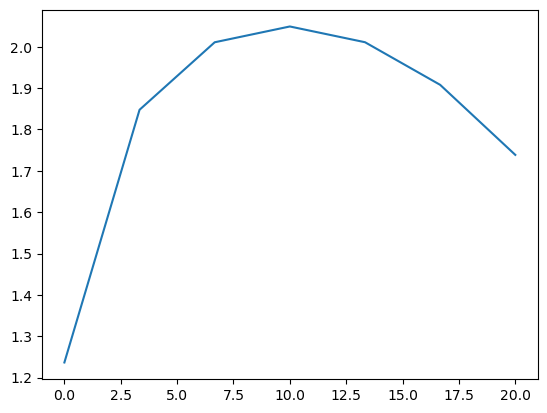

In [6]:
#solve nash bargaining with merged insurer

def calc_sharesm(p1, p2,  cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp - p1)/cost
    u2 = (wtp - p2)/cost
    s1 = np.exp(u1)/(np.exp(u1)+ np.exp(u2) + 1.25 )
    s2 = np.exp(u2)/(np.exp(u1)+ np.exp(u2) + 1.25 )
    
    return s1,s2


def profitsm(p,phi1,cost,wtp,mc1):
    shares = np.array(calc_sharesm(p[0],p[1],cost, wtp))
    profit =  ( shares * (np.array(p) -  phi1 - mc1 ) ).sum()
    return profit 
    
def calc_profits_price_sharesm(phi1,cost,wtp,mc1):
    pi = lambda p: -1*profitsm(p,phi1,cost,wtp,mc1)
    p = minimize(pi,[1,1],method='Nelder-Mead',tol=1e-4).x
    s1,s2 = calc_sharesm(p[0],p[1], cost, wtp)
    return p[0], p[1], s1 ,s2, s1*(p[0]-phi1 -mc1),s2*(p[1]-phi1 -mc1)


def nash_in_nash_objm(phi1, cost, wtp, mc1, beta=.5):
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_sharesm(phi1, cost, wtp, mc1)
    hosp_profit = s1*phi1 +s2*phi1
    obj = -1*(np.log(hosp_profit)*(1-beta) + np.log(profits1+profits2)*beta)
    #print(obj)
    return obj

def nash_in_nashm(cost,wtp,mc1):
    obj1 = lambda phi : nash_in_nash_objm(phi,cost,wtp,mc1)
    result = minimize(obj1,13,method='Nelder-Mead',tol=1e-4)
    
    return result.x[0]

print(nash_in_nashm(10,25,0))
print(calc_profits_price_sharesm(12.908554077148436,10,25,0))


COST = 5
WTP1 = 25
MC1 = 0

plt.plot([i for i in np.linspace(0,4*COST,num=7)], 
         [-1*nash_in_nash_objm(i, COST,WTP1,MC1) for i in np.linspace(1,4*COST,num=7)])

In [9]:
active_params = [[5,25],[6,25],[7,25]]
passive_params = [[ 5.8041324 , 69.87396866], [ 6.27539062, 78.27148438], [ 6.45077133, 81.54169083]]

for i in range(3):
    active_wtp =   np.array([active_params[i][1],active_params[i][1]])
    active_cost = active_params[i][0]
    #given p and reimb, solve for v and lambda?
    monop_pricea = nash_in_nashm(active_cost,active_wtp[0],MC[0])
    monop_prema = calc_profits_price_sharesm(monop_pricea,active_cost,active_wtp[0],MC[0])[0]
    
    passive_wtp =   np.array([passive_params[i][1],passive_params[i][1]])
    passive_cost = passive_params[i][0]
    monop_pricep = nash_in_nashm(passive_cost, passive_wtp[0], MC[0])
    monop_prem = calc_profits_price_sharesm(monop_pricep, passive_cost, passive_wtp[0], MC[0])[0]
    
    print(  round(monop_pricea,2),round(monop_prema,2),round(monop_pricep,2),round(monop_prem,2) )

10.35 24.39 29.24 63.4
10.59 25.47 32.83 71.01
10.94 26.71 34.21 73.98


In [10]:
active_params =  [[ 4.62780762, 12.21435547], [ 5.37875378, 12.25077868], [ 5.92254639, 12.16674805]]
passive_params = [[5,25],[6,25],[7,25]]

for i in range(3):
    active_wtp =   np.array([active_params[i][1],active_params[i][1]])
    active_cost = active_params[i][0]
    #given p and reimb, solve for v and lambda?
    monop_pricea = nash_in_nashm(active_cost,active_wtp[0],MC[0])
    monop_prema = calc_profits_price_sharesm(monop_pricea,active_cost,active_wtp[0],MC[0])[0]
    
    passive_wtp =   np.array([passive_params[i][1],passive_params[i][1]])
    passive_cost = passive_params[i][0]
    monop_pricep = nash_in_nashm(passive_cost, passive_wtp[0], MC[0])
    monop_prem = calc_profits_price_sharesm(monop_pricep, passive_cost, passive_wtp[0], MC[0])[0]
    
    print(  round(monop_pricea,2),round(monop_prema,2),round(monop_pricep,2),round(monop_prem,2) )

5.85 14.75 10.35 24.39
6.24 15.95 10.59 25.47
6.52 16.79 10.94 26.71
